# <center>  <font style="color:rgb(100,109,254)">Facial Expression Recognition</font> </center>

In [4]:
# Import Required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import bleedfacedetector as fd
import time
%matplotlib inline

## <font style="color:rgb(134,19,348)"> Initialize the DNN module </font>
To use Models in ONNX format, you just have to use **`cv2.dnn.readNetFromONNX(model)`** and pass the model inside the function.

In [2]:
# Set model path
model = 'Model/emotion-ferplus-8.onnx'
net = cv2.dnn.readNetFromONNX(model)

##  <font style="color:rgb(134,19,348)">Read Image</font> 


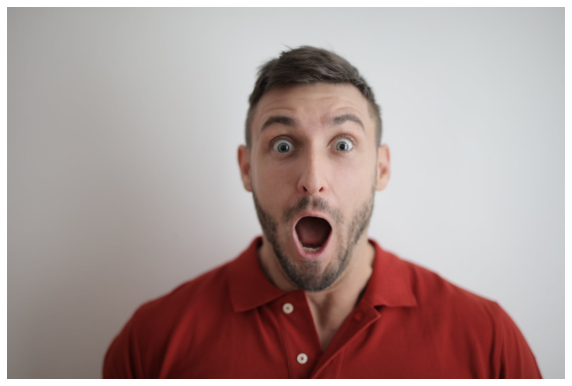

In [3]:
# Read image
image = cv2.imread("Media/emotion5.jpeg")

# Display image
plt.figure(figsize=[10,10])
plt.imshow(image[:,:,::-1])
plt.axis('off');

**We'll be predicting among these Emotions.**

In [4]:
# Define the emotions
emotions = ['Neutral', 'Happy', 'Surprise', 'Sad', 'Anger', 'Disgust', 'Fear', 'Contempt']

##  <font style="color:rgb(134,19,348)">Detect faces with bleedfacedetector</font> 

In [5]:
img_copy = image.copy()

# Use SSD detector with 20% confidence threshold.
faces = fd.ssd_detect(img_copy, conf=0.2)

# Check the number detected faces in image
print("{} faces detected".format(len(faces)))

# Lets take coordinates of the first face in the image. 
x,y,w,h = faces[0]

# Define padding for face roi
padding = 3

# extract the Face from image with padding.
padded_face = img_copy[y-padding:y+h+padding,x-padding:x+w+padding] 

1 faces detected


##  <font style="color:rgb(134,19,348)">Padded vs Non Padded face  </font>

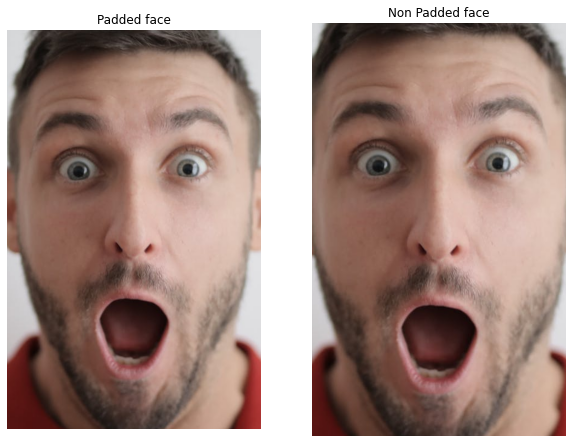

In [6]:
# Non Padded face
face = img_copy[y:y+h, x:x+w] 

# Just increasing the padding for demo purpose
padding = 20

# Get the Padded face
padded_face_demo = img_copy[y-padding:y+h+padding,x-padding:x+w+padding] 

plt.figure(figsize=[10, 10])
plt.subplot(121);plt.imshow(padded_face_demo[...,::-1]);plt.title("Padded face");plt.axis('off')
plt.subplot(122);plt.imshow(face[...,::-1]);plt.title("Non Padded face");plt.axis('off');

##  <font style="color:rgb(134,19,348)"> Pre-processing the image  </font>

In [7]:
gray = cv2.cvtColor(padded_face,cv2.COLOR_BGR2GRAY)
resized_face = cv2.resize(gray, (64, 64))
processed_face = resized_face.reshape(1,1,64,64)

## <font style="color:rgb(134,19,348)"> Input the Blob Image to the Network  </font>


In [8]:
net.setInput(processed_face)

##  <font style="color:rgb(134,19,348)">Forward Pass</font> 


In [9]:
%%time
Output = net.forward()

Wall time: 50 ms


In [10]:
# The output are the scores for each emotion class
print('Shape of Output: {} \n'.format(Output.shape))
print(Output)

Shape of Output: (1, 8) 

[[ 0.59999394 -0.05662632  7.56622    -3.5109608  -0.33248693 -3.9676816
   4.2001576  -3.1612003 ]]


###  <font style="color:rgb(134,19,348)">Apply Softmax function to get Class Probabilities</font> 
Now that we have scores for each class, we will convert these scores to probabilities between 0-1 by using a softmax function.

In [11]:
# Compute softmax values for each sets of scores  
expanded = np.exp(Output - np.max(Output))
probablities =  expanded / expanded.sum()

# Get the final probablities 
prob = np.squeeze(probablities)

print(prob)

[9.1010029e-04 4.7197891e-04 9.6490067e-01 1.4918463e-05 3.5819356e-04
 9.4487186e-06 3.3313509e-02 2.1165248e-05]


In [12]:
# Get the index of the max probability and that's your predicted emotion
predicted_emotion = emotions[prob.argmax()]

# Print the target Emotion
print('Predicted Emotion is :{}'.format(predicted_emotion ))

Predicted Emotion is :Surprise


##  <font style="color:rgb(134,19,348)">Display Image</font> 


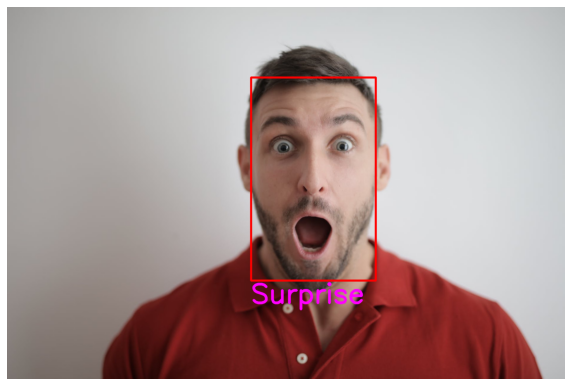

In [13]:
# Write predicted emotion on image
cv2.putText(img_copy,'{}'.format(predicted_emotion),(x,y+h+75), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,0,255), 7, cv2.LINE_AA)

# Draw rectangular box on detected face
cv2.rectangle(img_copy,(x,y),(x+w,y+h),(0,0,255),5)

# Display image
plt.figure(figsize=(10,10))
plt.imshow(img_copy[:,:,::-1]);plt.axis("off");

## <font style="color:rgb(134,19,348)"> Creating Functions </font> 

## <font style="color:rgb(134,19,348)"> Initialization Function </font>
This method will be run once and it will initialize the network with the required files.

In [1]:
def init_emotion(model="Model/emotion-ferplus-8.onnx"):
    
    # Set global variables
    global net,emotions
    
    # Define the emotions
    emotions = ['Neutral', 'Happy', 'Surprise', 'Sad', 'Anger', 'Disgust', 'Fear', 'Contempt']
    
    # Initialize the DNN module
    net = cv2.dnn.readNetFromONNX(model)

## <font style="color:rgb(134,19,348)">  Main Method </font>

In [8]:
def emotion(image, returndata=False, confidence=0.3):
    
    # Make copy of  image
    img_copy = image.copy()
    
    # Detect face in image
    faces = fd.ssd_detect(img_copy,conf=confidence)
    
    # Define padding for face ROI
    padding = 3 
    
    # Iterate process for all detected faces
    for x,y,w,h in faces:
        
        # Get the Face from image
        face = img_copy[y-padding:y+h+padding,x-padding:x+w+padding]
        
        # Convert the  detected face from BGR to Gray scale
        gray = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
        
        # Resize the gray scale image into 64x64
        resized_face = cv2.resize(gray, (64, 64))
        
        # Reshape the final image in required format of model
        processed_face = resized_face.reshape(1,1,64,64)
        
        # Input the processed image
        net.setInput(processed_face)
        
        # Forwards pass
        Output = net.forward()
 
        #Compute softmax values for each sets of scores  
        expanded = np.exp(Output - np.max(Output))
        probablities =  expanded / expanded.sum()
        
        # Get the final probablities 
        prob = np.squeeze(probablities)
        
        # Get the predicted emotion
        predicted_emotion = emotions[prob.argmax()]
       
        # Write predicted emotion on image
        cv2.putText(img_copy,'{}'.format(predicted_emotion),(x,y+h+(1*20)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 
                        2, cv2.LINE_AA)
        # Draw rectangular box on detected face
        cv2.rectangle(img_copy,(x,y),(x+w,y+h),(0,0,255),2)
    
    if  returndata:
        # Return the the final image if return data is is True
        return img_copy
    else:
        # Displpay the image
        plt.figure(figsize=(10,10))
        plt.imshow(img_copy[:,:,::-1]);plt.axis("off");          

**Initialize the Emotion Recognizer**

In [9]:
init_emotion()

**Calling Emotion Recognizer with default arguments.**

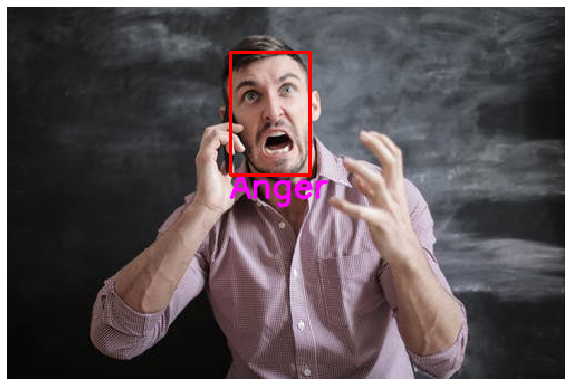

In [10]:
image = cv2.imread("Media/emotion1.jpeg")
emotion(image)

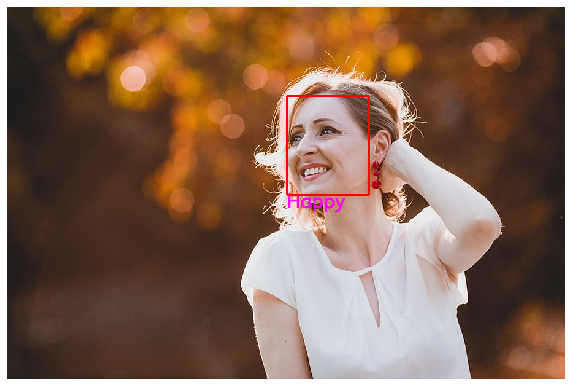

In [11]:
image = cv2.imread("Media/emotion2.jpg")
emotion(image)

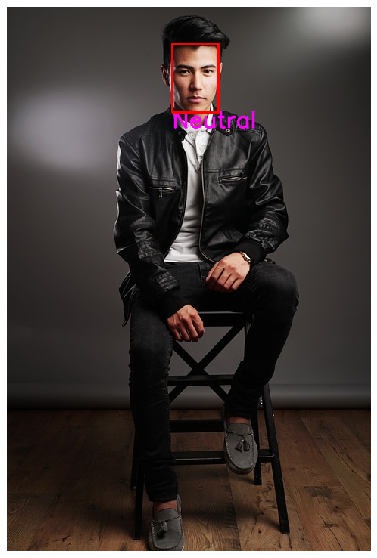

In [12]:
image = cv2.imread("Media/emotion4.jpg")
emotion(image)

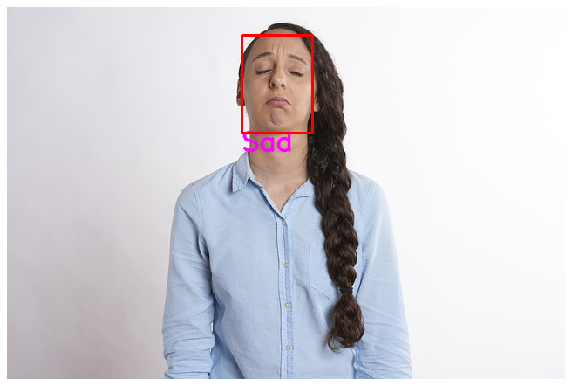

In [14]:
image = cv2.imread("Media/emotion3.jpg")
emotion(image)

## <font style="color:rgb(134,19,348)"> Real time Emotion Recognition</font>

In [17]:
fps=0
init_emotion()
cap = cv2.VideoCapture('media/bean_input.mp4')

# If you want to use the webcam the pass 0
# cap = cv2.VideoCapture(0)


while(True):    
    
    start_time = time.time()
    ret,frame=cap.read() 
    
    if not ret:
        break
        
    image = cv2.flip(frame,1)
    
    image = emotion(image, returndata=True, confidence = 0.8)
    
    cv2.putText(image, 'FPS: {:.2f}'.format(fps), (10, 20), cv2.FONT_HERSHEY_SIMPLEX,0.8, (255, 20, 55), 1)
    cv2.imshow("Emotion Recognition",image)
    
    k = cv2.waitKey(1)
    fps= (1.0 / (time.time() - start_time))
    
    if k == ord('q'):
        break
cap.release() 
cv2.destroyAllWindows() 